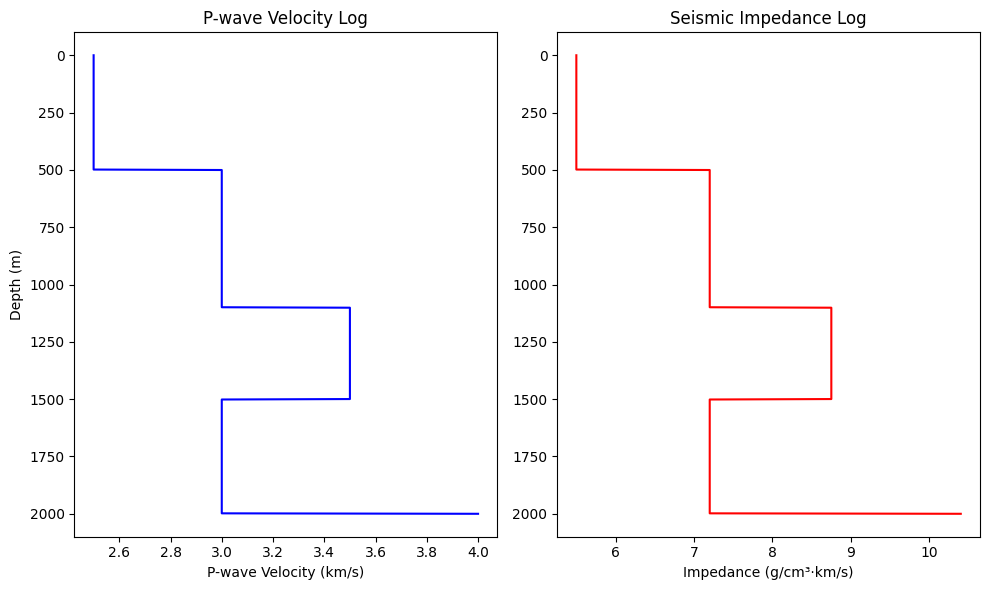

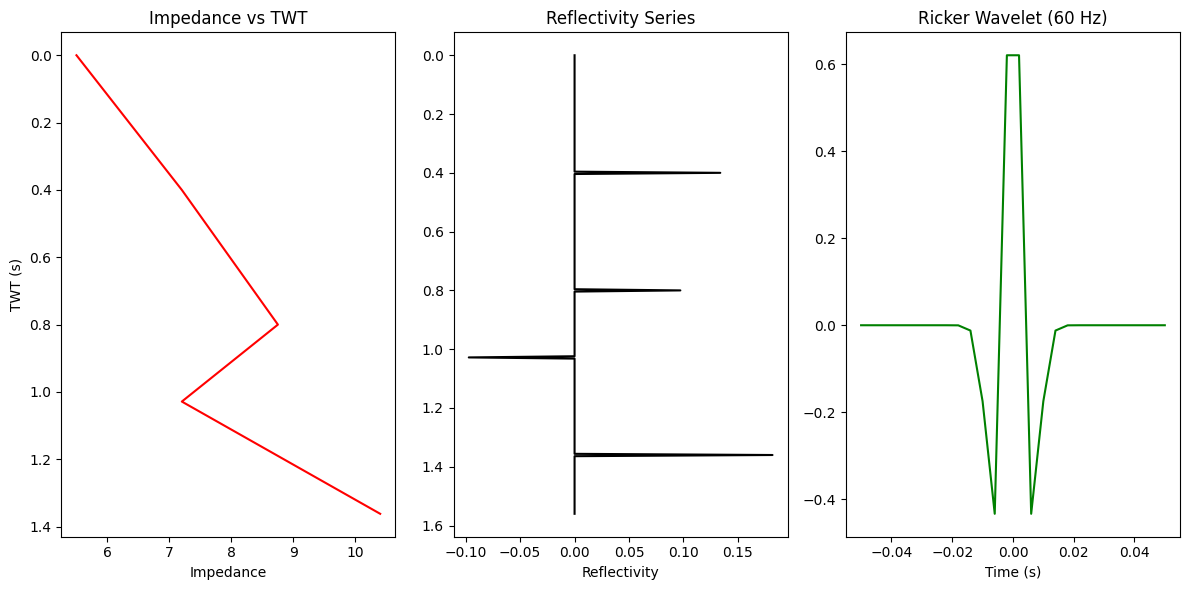

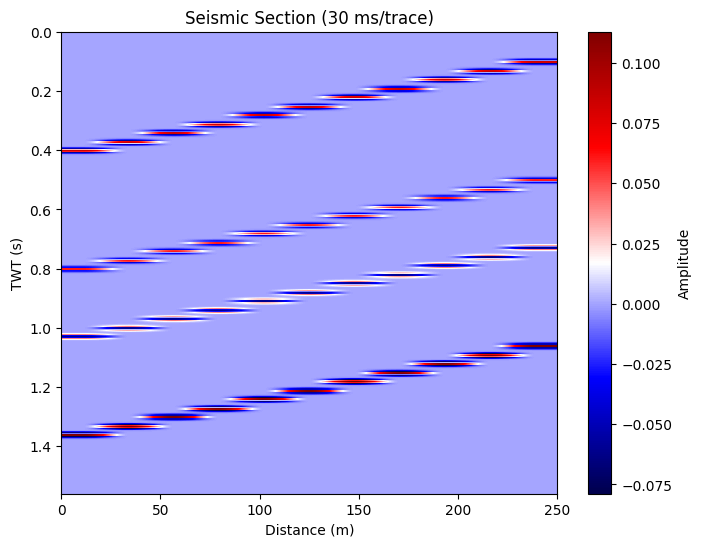

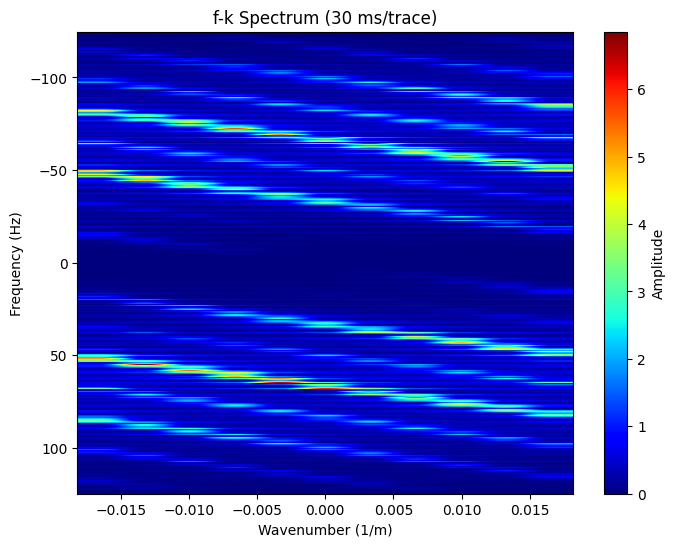

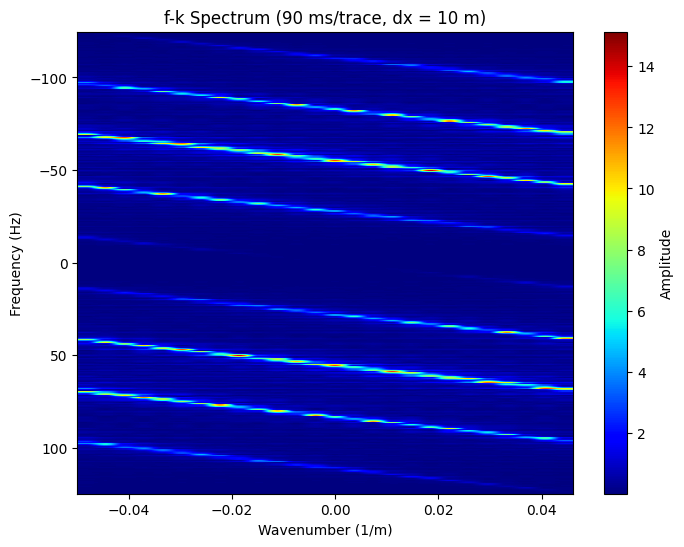

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

# Constants
depths = [0, 500, 1100, 1500, 2000, np.inf]  # meters
vp = [2.5, 3, 3.5, 3, 4]  # km/s
rho = [2.2, 2.4, 2.5, 2.4, 2.6]  # g/cm³
f_peak = 60  # Hz (Ricker wavelet)
dt = 0.004  # 4 ms sample interval
dx = 25  # 25 m trace interval
n_traces = 11  # 11 traces

# --- 1(a): P-wave Velocity and Impedance Logs ---
z = np.array([rho[i] * vp[i] for i in range(len(vp))])  # Impedance
depth_array = np.linspace(0, 2000, 1000)
vp_log = np.zeros_like(depth_array)
z_log = np.zeros_like(depth_array)
for i in range(len(depths) - 1):
    mask = (depth_array >= depths[i]) & (depth_array < depths[i + 1])
    vp_log[mask] = vp[i]
    z_log[mask] = z[i]

plt.figure(figsize=(10, 6))
plt.subplot(121)
plt.plot(vp_log, depth_array, 'b')
plt.gca().invert_yaxis()
plt.xlabel('P-wave Velocity (km/s)')
plt.ylabel('Depth (m)')
plt.title('P-wave Velocity Log')
plt.subplot(122)
plt.plot(z_log, depth_array, 'r')
plt.gca().invert_yaxis()
plt.xlabel('Impedance (g/cm³·km/s)')
plt.title('Seismic Impedance Log')
plt.tight_layout()
plt.show()

# --- 1(b) & 1(c): Reflectivity, Convolution, Two-Way Time ---
# Reflection coefficients
r = [(z[i + 1] - z[i]) / (z[i + 1] + z[i]) for i in range(len(z) - 1)]
interfaces = [500, 1100, 1500, 2000]  # meters

# Two-way time calculation
twt = [0]
for i in range(4):
    twt.append(twt[-1] + 2 * (interfaces[i] - (interfaces[i-1] if i > 0 else 0)) / vp[i])
twt = np.array(twt) / 1000  # Convert to seconds

# Reflectivity in time
t_max = twt[-1] + 0.2
t = np.arange(0, t_max, dt)
reflectivity = np.zeros_like(t)
for i, t_i in enumerate(twt[1:]):
    idx = np.argmin(np.abs(t - t_i))
    reflectivity[idx] = r[i]

# Ricker wavelet
t_wave = np.arange(-0.05, 0.051, dt)
wavelet = (1 - 2 * (np.pi * f_peak * t_wave)**2) * np.exp(-(np.pi * f_peak * t_wave)**2)

# Convolution
seismic_trace = signal.convolve(reflectivity, wavelet, mode='same')

plt.figure(figsize=(12, 6))
plt.subplot(131)
plt.plot(z, twt, 'r')
plt.gca().invert_yaxis()
plt.xlabel('Impedance')
plt.ylabel('TWT (s)')
plt.title('Impedance vs TWT')
plt.subplot(132)
plt.plot(reflectivity, t, 'k')
plt.gca().invert_yaxis()
plt.xlabel('Reflectivity')
plt.title('Reflectivity Series')
plt.subplot(133)
plt.plot(t_wave, wavelet, 'g')
plt.xlabel('Time (s)')
plt.title('Ricker Wavelet (60 Hz)')
plt.tight_layout()
plt.show()

# --- 1(d): Seismic Section ---
seismic_section = np.tile(seismic_trace[:, np.newaxis], (1, n_traces))
t_samples = len(t)

# Rotated sections
slopes = [10, 20, 30, 40, 50, 60, 70, 80, 90]  # ms/trace
rotated_sections = []
for slope in slopes:
    rotated = np.zeros_like(seismic_section)
    for i in range(n_traces):
        shift = int(slope * i / (dt * 1000))  # Convert ms to samples
        if shift < t_samples:
            rotated[:t_samples - shift, i] = seismic_section[shift:, i]
    rotated_sections.append(rotated)

# Plot one example (e.g., 30 ms/trace)
plt.figure(figsize=(8, 6))
plt.imshow(rotated_sections[2], aspect='auto', cmap='seismic', extent=[0, dx * (n_traces - 1), t[-1], 0])
plt.xlabel('Distance (m)')
plt.ylabel('TWT (s)')
plt.title('Seismic Section (30 ms/trace)')
plt.colorbar(label='Amplitude')
plt.show()

# --- 2(a): f-k Spectrum ---
fk_spectra = []
for section in rotated_sections:
    fk = np.fft.fft2(section)
    fk_shifted = np.fft.fftshift(fk)
    fk_spectra.append(np.abs(fk_shifted))

# Frequency and wavenumber axes
f = np.fft.fftfreq(t_samples, dt)
k = np.fft.fftfreq(n_traces, dx)
f_shifted = np.fft.fftshift(f)
k_shifted = np.fft.fftshift(k)

# Plot f-k for 30 ms/trace
plt.figure(figsize=(8, 6))
plt.imshow(fk_spectra[2], aspect='auto', cmap='jet', extent=[k_shifted[0], k_shifted[-1], f_shifted[-1], f_shifted[0]])
plt.xlabel('Wavenumber (1/m)')
plt.ylabel('Frequency (Hz)')
plt.title('f-k Spectrum (30 ms/trace)')
plt.colorbar(label='Amplitude')
plt.show()

# --- 2(b) & 2(c): Aliasing Check and Fix ---
# Check aliasing: k_max = 1 / (2 * dx) = 0.02 m^-1
# For steep slopes (e.g., 90 ms/trace), reduce dx to 10 m
dx_new = 10
n_traces_new = int(dx * (n_traces - 1) / dx_new) + 1
seismic_section_new = np.tile(seismic_trace[:, np.newaxis], (1, n_traces_new))
rotated_new = np.zeros((t_samples, n_traces_new))
slope = 90  # Example
for i in range(n_traces_new):
    shift = int(slope * i * (dx_new / dx) / (dt * 1000))
    if shift < t_samples:
        rotated_new[:t_samples - shift, i] = seismic_section_new[shift:, i]

fk_new = np.abs(np.fft.fftshift(np.fft.fft2(rotated_new)))
k_new = np.fft.fftshift(np.fft.fftfreq(n_traces_new, dx_new))

plt.figure(figsize=(8, 6))
plt.imshow(fk_new, aspect='auto', cmap='jet', extent=[k_new[0], k_new[-1], f_shifted[-1], f_shifted[0]])
plt.xlabel('Wavenumber (1/m)')
plt.ylabel('Frequency (Hz)')
plt.title('f-k Spectrum (90 ms/trace, dx = 10 m)')
plt.colorbar(label='Amplitude')
plt.show()